In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('/home/jovyan/sac-odc-hub/dcal_utils/')

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# **Landsat-8 WOFS Product Creation**

### Config

In [4]:
import datacube
dc = datacube.Datacube(app="List Products")

In [5]:
area_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              177.481,
              -18.00
            ],
            [
              177.855,
              -18.00
            ],
            [
              177.855,
              -18.3732
            ],
            [
              177.481,
              -18.3732
            ],
            [
              177.481,
              -18.00
            ]
          ]
        ]
      }
    }
  ]
}

In [6]:
lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])

In [7]:
lat_extents = (min(lats), max(lats))
lon_extents = (min(lons), max(lons))

print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-18.3732, -18.0) 
Lon: (177.481, 177.855)


### Load Data

Generic query specs

In [28]:
from datetime import datetime

query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = (datetime(2018,12,28), datetime(2019,1,1)),
                resolution = (10,10))

Dataset-specifics

In [ ]:
scenes = dc.load(product="s2_esa_sr_granule",
               group_by='solar_day',
               measurements = ["green","red","blue","nir","swir_1","swir_2","coastal_aerosol","scene_classification"],
               **query)

In [27]:
scenes

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

Check loaded

In [16]:
scenes.isel(time = 0).swir_1.plot();

ValueError: dimensions ['time'] do not exist

Create + apply 'cleansky' mask

In [66]:
from clean_mask import landsat_qa_clean_mask

clearsky_masks = landsat_qa_clean_mask(scenes, 'LANDSAT_8')
clearsky_scenes = scenes.where(clearsky_masks)

Apply wofs classification

In [75]:
from dc_water_classifier import wofs_classify
water_classes = wofs_classify(scenes, no_data = np.nan, x_coord='x', y_coord = "y")

Visualise wofs summary product

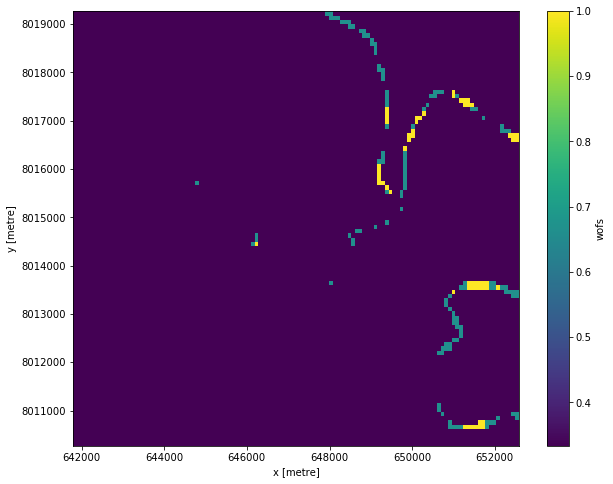

In [85]:
plt.figure(figsize = (10,8))
water_classes.wofs.mean(dim = 'time').plot()